In [1]:
import numba
import sys
sys.path.insert(0, '../python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import random
from collections import defaultdict
import torch
import math
import solvers
import imp

In [2]:
%matplotlib inline

# Spin system on tree network

### inter_H -> random external fields

### j_start -> values of ferromagnet interactions

We generate a tree:
1. ordered from a root
2. non-ordered (the same nodes are swapped)

In [263]:
Degree = 3 # degree
Height = 3 # Height of the tree

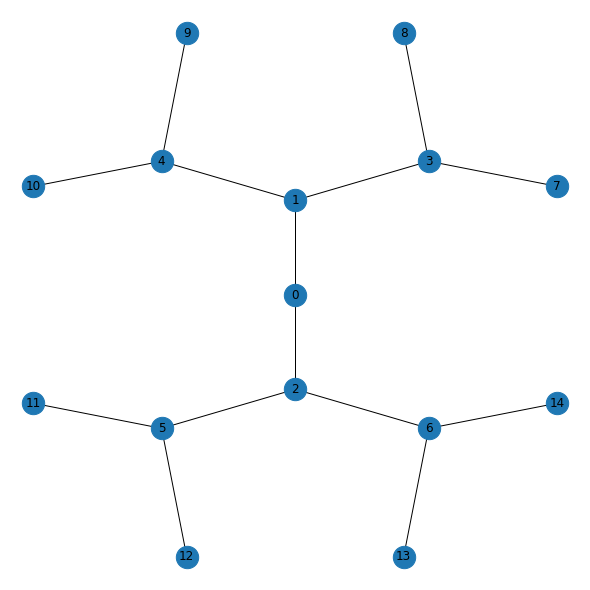

[[8, 2], [3, 12], [1, 4]]


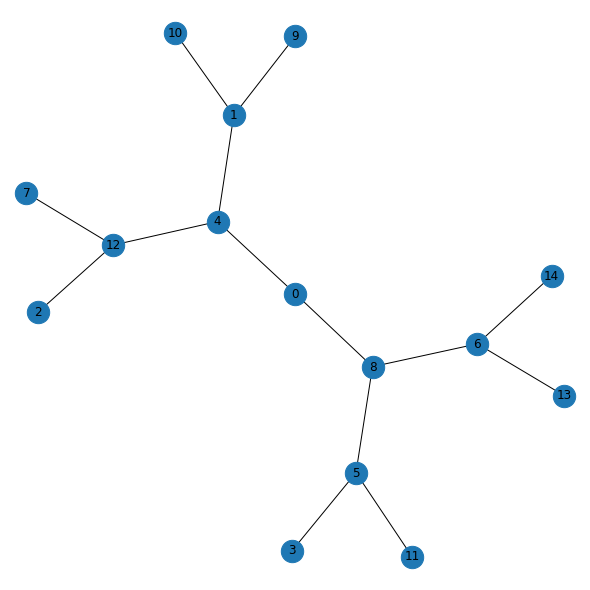

In [264]:
import imp 

import graph_gen
imp.reload(graph_gen)
N, J_interaction = graph_gen.tree_interaction(Degree,Height)

inter_H = 4
H = inter_H * (2.* np.random.random(N) - 1)
H = np.zeros(N)

num_swap = 3
J_interaction_rand, H_rand = graph_gen.order_rand(N, 
                                                  J_interaction, 
                                                  H, num_swap=num_swap)

graph_gen.plot_matrix_graph(J_interaction_rand)

betas = np.arange(1e-6,2,1e-2)
betas_fast = np.arange(0.1,2,4e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

# Exact solutions
enumerating all configurations.

In [265]:
import model
imp.reload(model)
tree = model.model(N, H, J, J_interaction)
tree_rand = model.model(N, H_rand, J_rand, J_interaction_rand)

In [266]:
beta = 0.2
tree.exact(beta)
tree_rand.exact(beta);

beta: 0.2, Fe: -3.558 Energy: -0.184 M: 0.0 S: 0.6753.16
beta: 0.2, Fe: -3.558 Energy: -0.184 M: 0.0 S: 0.6753.29


# Neural network solutions
## ordered case

In [218]:
import bp_nn
imp.reload(bp_nn)
bias = True
net = bp_nn.bp_nn(tree.N, tree, bias, z2=False)
net.train(beta=beta, 
          lr=0.01, 
        batch_size=1000,
         std_fe_limit=0.00001, 
)
net.compute_stat_is(beta, batch_size=10000)

 0.20 2087 fe: -3.558 +- 0.00001 E: -0.189, S: 0.674, M: 0.0233, B1 = -0.000
free_energy: -3.558,  std_fe: 0.00000, mag_mean: 0.008, entropy: 0.675 energy: -0.182

tensor(-3.5585, dtype=torch.float64)

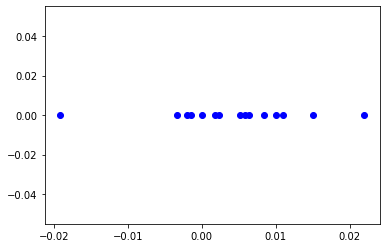

In [219]:
import matplotlib.pyplot as plt
plt.plot(net.M_i,tree.M_i_mean , 'bo')

In [220]:
tree_c = tree.Corr_neigh.flatten()
nn_c = net.Corr_neigh.numpy().flatten()
tree_c = tree_c[tree_c != 0]
nn_c = nn_c[nn_c != 0]

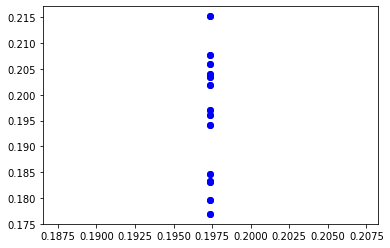

In [221]:
import matplotlib.pyplot as plt

plt.plot(tree_c, nn_c , 'bo');

In [222]:
tree_c = tree.Corr.flatten()
nn_c = net.Corr.numpy().flatten()
tree_c = tree_c[tree_c != 0]
nn_c = nn_c[nn_c != 0]

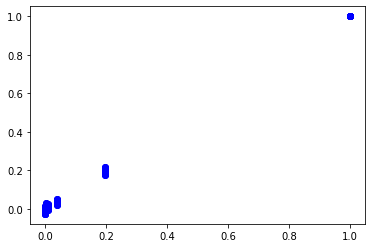

In [223]:
import matplotlib.pyplot as plt

plt.plot(tree_c, nn_c , 'bo');

# NN deep no deep

In [267]:
import bp_nn_deep
imp.reload(bp_nn_deep)

neighs = bp_nn_deep.find_neigh(tree)
in_out_layers = []
for n_i in range(tree.N):
    in_ = len(neighs[n_i]) if len(neighs[n_i]) else 1
    in_out_layers.append([in_, 1])

In [268]:
import bp_nn_deep
imp.reload(bp_nn_deep)
bias = True

net = bp_nn_deep.bp_nn_deep(tree, bias, in_out_layers, neighs)

In [273]:
import bp_nn_more
imp.reload(bp_nn_deep)
bias = True

net = bp_nn_deep.bp_nn_deep(tree, bias, in_out_layers, neighs)
net.train(beta=beta, 
          lr=0.01, 
        batch_size=1000,
         std_fe_limit=0.00001, 
)
net.compute_stat_is(beta, batch_size=10000)

 0.20 2076 fe: -3.374 +- 0.00001 E: -0.183, S: 0.638, M: 0.02893
free_energy: -3.374,  std_fe: 0.00000, mag_mean: 0.007, entropy: 0.638 energy: -0.183

tensor(-3.3737, dtype=torch.float64)

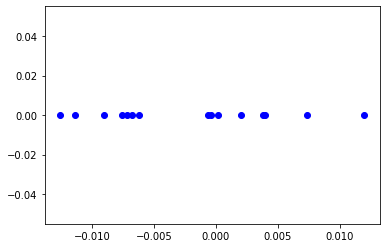

In [227]:
import matplotlib.pyplot as plt
plt.plot(net.M_i,tree.M_i_mean , 'bo')

In [228]:
tree_c = tree.Corr.flatten()
nn_c = net.Corr.numpy().flatten()
tree_c = tree_c[tree_c != 0]
nn_c = nn_c[nn_c != 0]

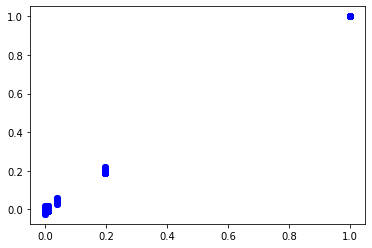

In [229]:
import matplotlib.pyplot as plt

plt.plot(tree_c, nn_c , 'bo');

## random case

In [230]:
import bp_nn
imp.reload(bp_nn)

net_rand = bp_nn.bp_nn(tree_rand.N, tree_rand, True, z2=False, init_zero=False,)
                      
net_rand.train(beta=beta, lr=0.01, 
           max_step=10000,
               opt="adam")


 0.20 10000 fe: -3.558 +- 0.01314 E: -0.192, S: 0.673, M: 0.0269, B1 = 0.002

{'free_energy_mean': tensor(-3.5585, dtype=torch.float64),
 'free_energy_std': tensor(0.0131, dtype=torch.float64),
 'entropy_mean': tensor(0.6733, dtype=torch.float64, grad_fn=<DivBackward0>),
 'energy_mean': tensor(-0.1919, dtype=torch.float64),
 'mag': tensor([ 0.0380, -0.0280,  0.0220, -0.0200,  0.0200, -0.0240,  0.0120, -0.0320,
          0.0120,  0.0120,  0.0680, -0.0560, -0.0220,  0.0140,  0.0240]),
 'mag_mean': tensor(0.0269)}

In [231]:
net_rand.compute_stat_is(beta, batch_size=10000)


free_energy: -3.558,  std_fe: 0.00001, mag_mean: 0.008, entropy: 0.675 energy: -0.184

tensor(-3.5584, dtype=torch.float64)

## random case with deep

In [232]:
import bp_nn_deep
imp.reload(bp_nn_deep)

neighs = bp_nn_deep.find_neigh(tree)
in_out_layers = []
for n_i in range(tree.N):
    in_ = len(neighs[n_i]) if len(neighs[n_i]) else 1
    in_out_layers.append([in_, 1])

In [1]:
in_out_layers

NameError: name 'in_out_layers' is not defined

# Large networks BP solution

In [233]:
Degree = 3 # degree
Height = 6 # Height of the tree

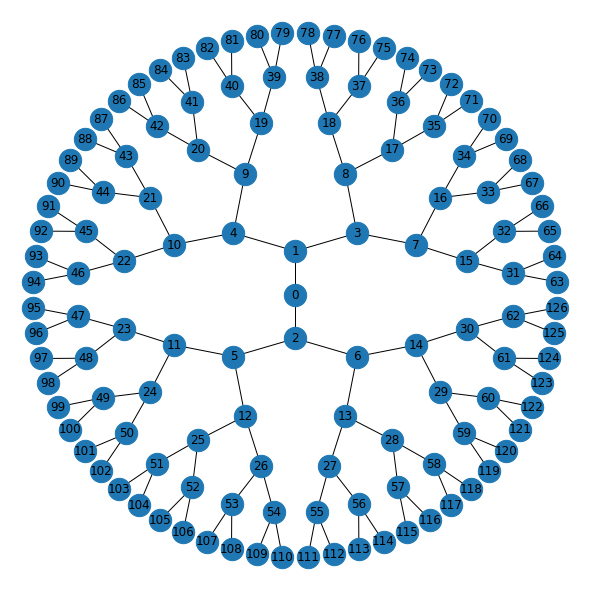

[[35, 37], [123, 18], [108, 79]]


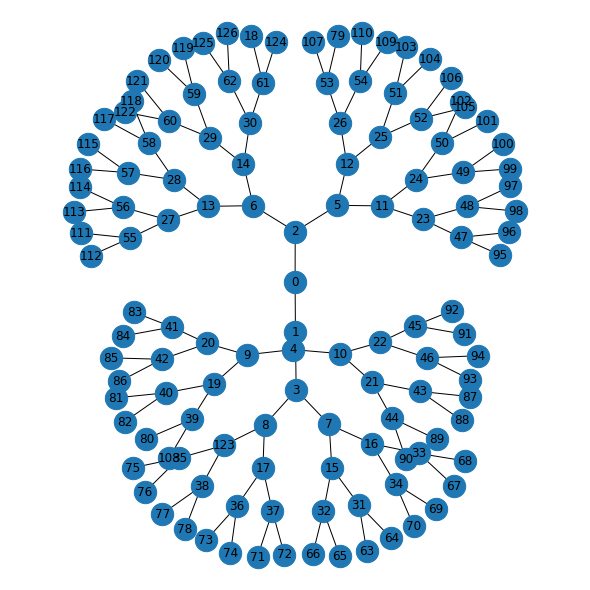

In [234]:
import imp 

import graph_gen
imp.reload(graph_gen)
N, J_interaction = graph_gen.tree_interaction(Degree,Height)

inter_H = 4
H = inter_H * (2.* np.random.random(N) - 1)
#H = np.zeros(N)

num_swap = 3
J_interaction_rand, H_rand = graph_gen.order_rand(N, 
                                                  J_interaction, 
                                                  H, num_swap=num_swap)

graph_gen.plot_matrix_graph(J_interaction_rand)

betas = np.arange(1e-6,2,1e-2)
betas_fast = np.arange(0.1,2,4e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

In [235]:
import model
imp.reload(model)
tree = model.model(N, H, J, J_interaction)
tree_rand = model.model(N, H_rand, J_rand, J_interaction_rand)

In [236]:
import bp_solver
bp_sol = bp_solver.BP_solver(tree)
beta = 0.2

In [238]:
bp_sol.converge(beta)

fe: -4.043, ener: -1.082, M: 0.364, iter 8


In [239]:
bp_sol.free_energy(beta)

-4.043164119293446

In [240]:
import bp_nn
imp.reload(bp_nn)
bias = True
net = bp_nn.bp_nn(tree.N, tree, bias, z2=False)
net.train(beta=beta, 
          lr=0.01, 
        batch_size=1000,
         std_fe_limit=0.00001, 
)
net.compute_stat_is(beta, batch_size=10000)

 0.20 2050 fe: -4.043 +- 0.00001 E: -1.089, S: 0.591, M: 0.366, B1 = 1.228
free_energy: -4.043,  std_fe: 0.00000, mag_mean: 0.364, entropy: 0.592 energy: -1.084

tensor(-4.0432, dtype=torch.float64)

In [241]:
net.compute_stat_is(beta, batch_size=10000)


free_energy: -4.043,  std_fe: 0.00000, mag_mean: 0.363, entropy: 0.592 energy: -1.082

tensor(-4.0432, dtype=torch.float64)

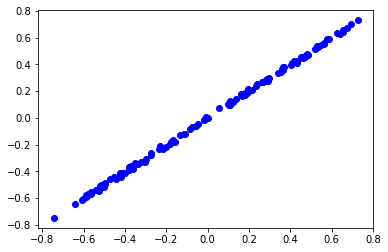

In [242]:
import matplotlib.pyplot as plt
plt.plot(net.M_i,bp_sol.M_i , 'bo')

In [243]:
tree_c = bp_sol.Corr_neigh.flatten()
nn_c = net.Corr_neigh.numpy().flatten()
tree_c = tree_c[tree_c != 0]
nn_c = nn_c[nn_c != 0]

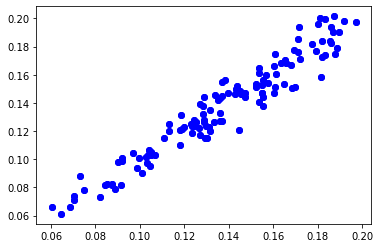

In [244]:
import matplotlib.pyplot as plt

plt.plot(tree_c, nn_c , 'bo');

In [245]:
# deep

In [246]:
import bp_nn_deep
imp.reload(bp_nn_deep)

neighs = bp_nn_deep.find_neigh(tree)
in_out_layers = []
for n_i in range(tree.N):
    in_ = len(neighs[n_i]) if len(neighs[n_i]) else 1
    in_out_layers.append([in_, 1])

In [259]:
import bp_nn_more
imp.reload(bp_nn_deep)
bias = True

net = bp_nn_deep.bp_nn_deep(tree, bias, in_out_layers, neighs)
net.train(beta=beta, 
          lr=0.01, 
        batch_size=1000,
         std_fe_limit=0.00001, 
)
net.compute_stat_is(beta, batch_size=10000)

 0.20 9 fe: -3.250 +- 0.24771 E: -0.130, S: 0.624, M: 0.258

KeyboardInterrupt: 